In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

from rapidgbm import RapidGBMTuner

import mplhep as hep
hep.style.use([hep.style.ATLAS])

import seaborn as sns

In [46]:
data1 = pd.read_parquet('/groups/hep/kinch/pred_e_m/samples_processed/Zee1.parquetoutput.parquet')
data2 = pd.read_parquet('/groups/hep/kinch/pred_e_m/samples_processed/Zee2.parquetoutput.parquet')
data3 = pd.read_parquet('/groups/hep/kinch/pred_e_m/samples_processed/Zee3.parquetoutput.parquet')

In [47]:
data = pd.concat([data1, data2, data3])

In [48]:
drop_list = ['runNumber', 'eventNumber', 'mcEventNumber', 'el_index', 'el_firstEgMotherTruthType',
       'el_firstEgMotherTruthOrigin', 'truthType',
       'truthOrigin', 'neflowisol20','truthel_e_dressed', 
       'truthel_pt_dressed', 'truthel_eta_dressed',
       'truthel_phi_dressed', 'truthel_m', 'truthel_px', 'truthel_py',
       'truthel_pz', 'truthel_E', 'truthel_pdgId', 'truthel_ptcone30',
       'truthel_etcone20', 'truthel_ParticleOrigin', 'truthel_Classification',
       'truthel_barcode', 'truthel_status', 'truthel_nPhotons_dressed', 'truth_dR', 'pt', 'm']

In [49]:
print(f'{np.sum(data['truthOrigin']==13)/len(data)*100.:.2f}% of the data is from Z bosons')

24.42% of the data is from Z bosons


In [50]:
# balance the data
data_z = data[data['truthOrigin']==13]
data_non_z = data[data['truthOrigin']!=13].sample(len(data_z), random_state=12)
data = pd.concat([data_z, data_non_z])

print(f'{np.sum(data['truthOrigin']==13)/len(data)*100.:.2f}% of the data is from Z bosons')

50.00% of the data is from Z bosons


In [51]:
# split the data

X_train, X_test, y_train, y_test = train_test_split(data, data['truthOrigin']==13, test_size=0.2, random_state=42)

X_test_full = X_test.copy()
X_train.drop(drop_list, axis=1, inplace=True)
X_test.drop(drop_list, axis=1, inplace=True)
print(X_train.columns)


Index(['eta', 'phi', 'charge', 'm', 'f1', 'DNN_pel', 'DNN_pcf', 'DNN_ppc',
       'DNN_phf', 'DNN_ple', 'DNN_plh', 'el_DFCommonElectronsECIDS',
       'el_DFCommonElectronsECIDSResult', 'GSF_dR', 'GSF_d0', 'GSF_z0',
       'GSF_theta', 'GSF_phi', 'GSF_qOverP', 'GSF_chiSquared', 'GSF_var_0',
       'GSF_var_1', 'GSF_var_2', 'GSF_var_3', 'GSF_var_4', 'InDet_dR',
       'InDet_d0', 'InDet_z0', 'InDet_theta', 'InDet_phi', 'InDet_var_0',
       'InDet_var_1', 'InDet_var_2', 'InDet_var_3', 'InDet_var_4',
       'ptvarcone20', 'topoetcone20', 'topoetcone40',
       'el_ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt1000',
       'el_ptcone20_Nonprompt_All_MaxWeightTTVALooseCone_pt1000',
       'el_ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt1000_CloseByCorr',
       'el_topoetcone20_CloseByCorr',
       'el_ptcone20_Nonprompt_All_MaxWeightTTVALooseCone_pt1000_CloseByCorr',
       'el_core57cellsEnergyCorrection', 'el_topoetcone20ptCorrection',
       'el_ptcone20_Nonprompt_All_MaxW


 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 100 trials
     .. Evaluation metric: auc 
     .. Study direction: minimize log_loss

     . Trial number: 0 finished
     .. Optimization score (lower-better): log_loss: 0.0483275510189154
     .. Evaluation score (greater-better): auc: 0.9982899816162901
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): log_loss: 0.04848782286744493
     .. Evaluation score (greater-better): auc: 0.9983261592789967
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): log_loss: 0.0881342035240109
     .. Evaluation score (greater-better): auc: 0.9975395880794075
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-better): log_loss: 0.04806740906234944
  

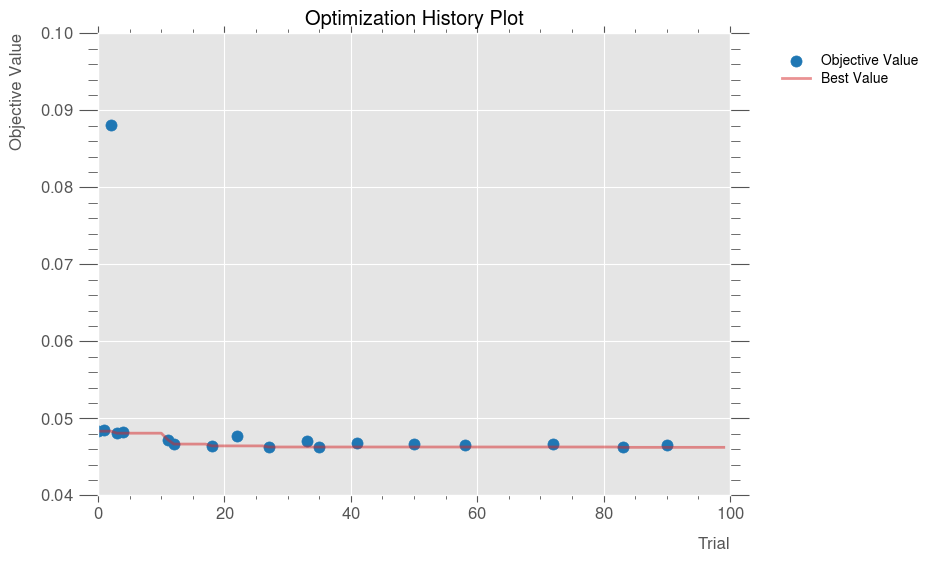

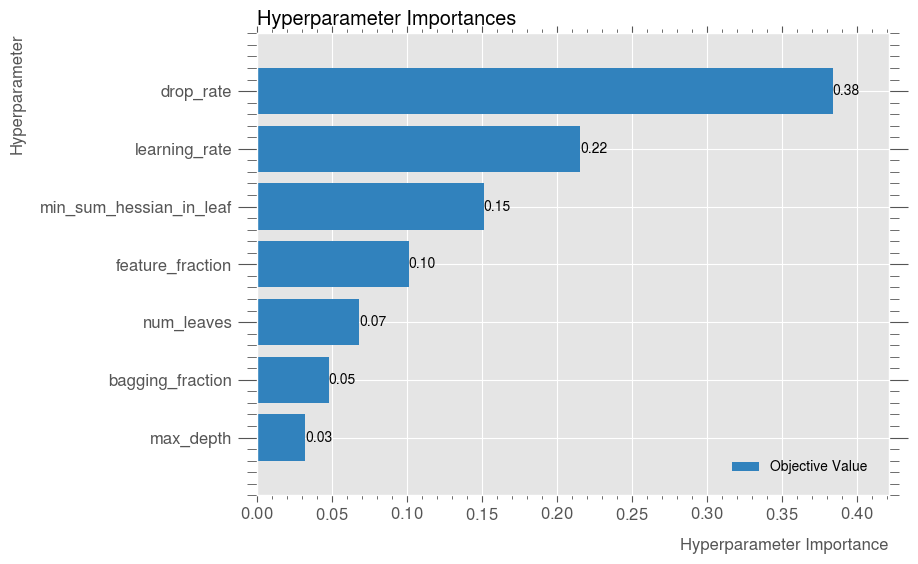

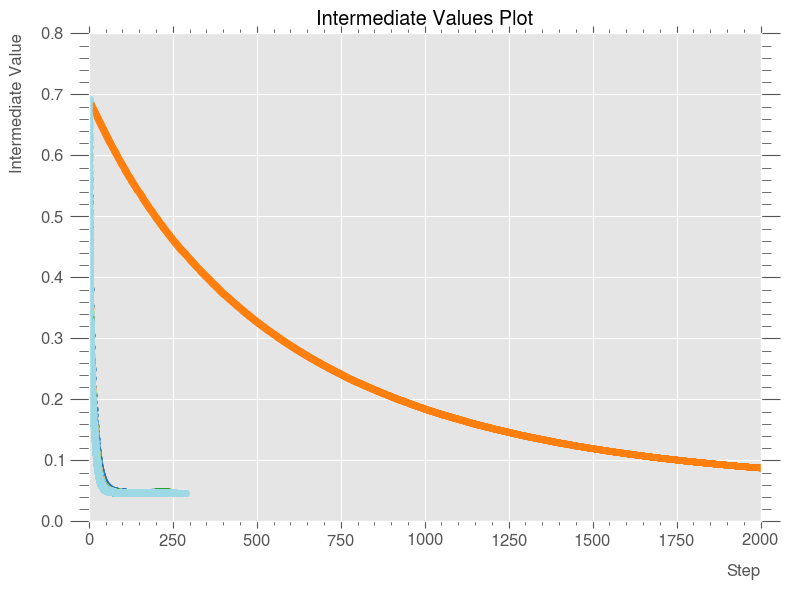

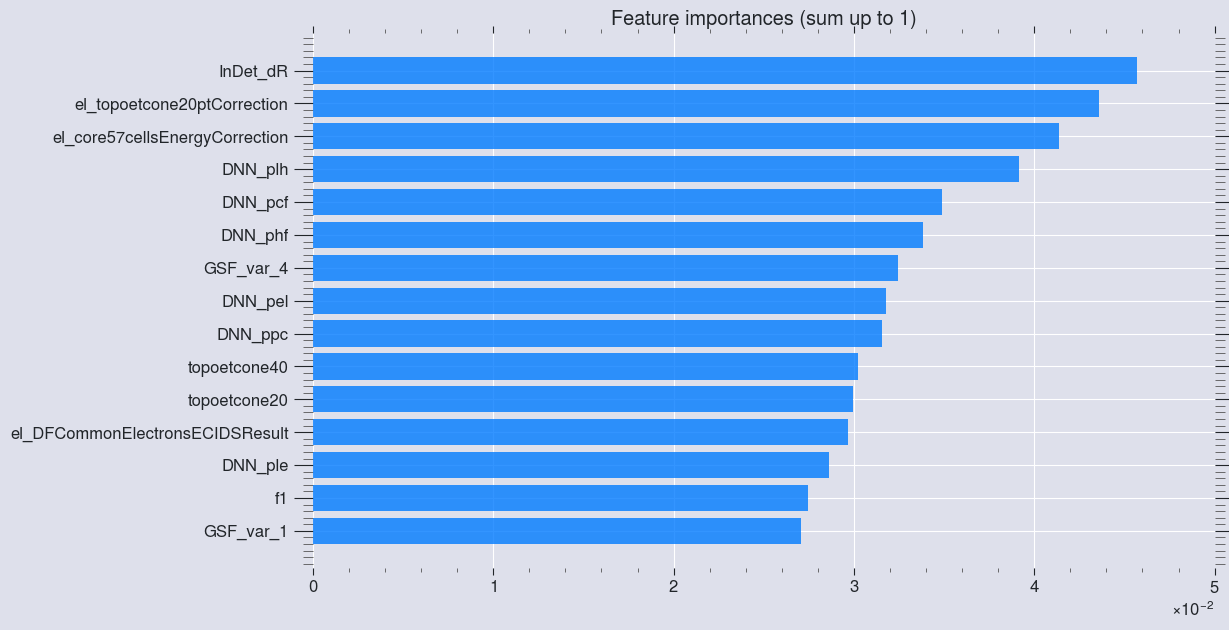


     . Optuna hyperparameters optimization finished
     .. Best trial number:83    |     log_loss:         0.046228831053091925
 ---------------------------------------------------------------------------

Time elapsed for fit execution: 9 min 54.873 sec


In [52]:
tuner = RapidGBMTuner(metric='auc', trials=100, refit=True, verbosity=1, visualization=True, seed=414243)#, grid='h,learning_rate')

tuner.grid['max_depth'] = (0, 100)
tuner.grid['learning_rate'] = (0.00001, 0.1)
tuner.grid['drop_rate'] = (0.05,0.4)
# Fit tuner for each set of input_data
tuner.fit(X_train, y_train)

no


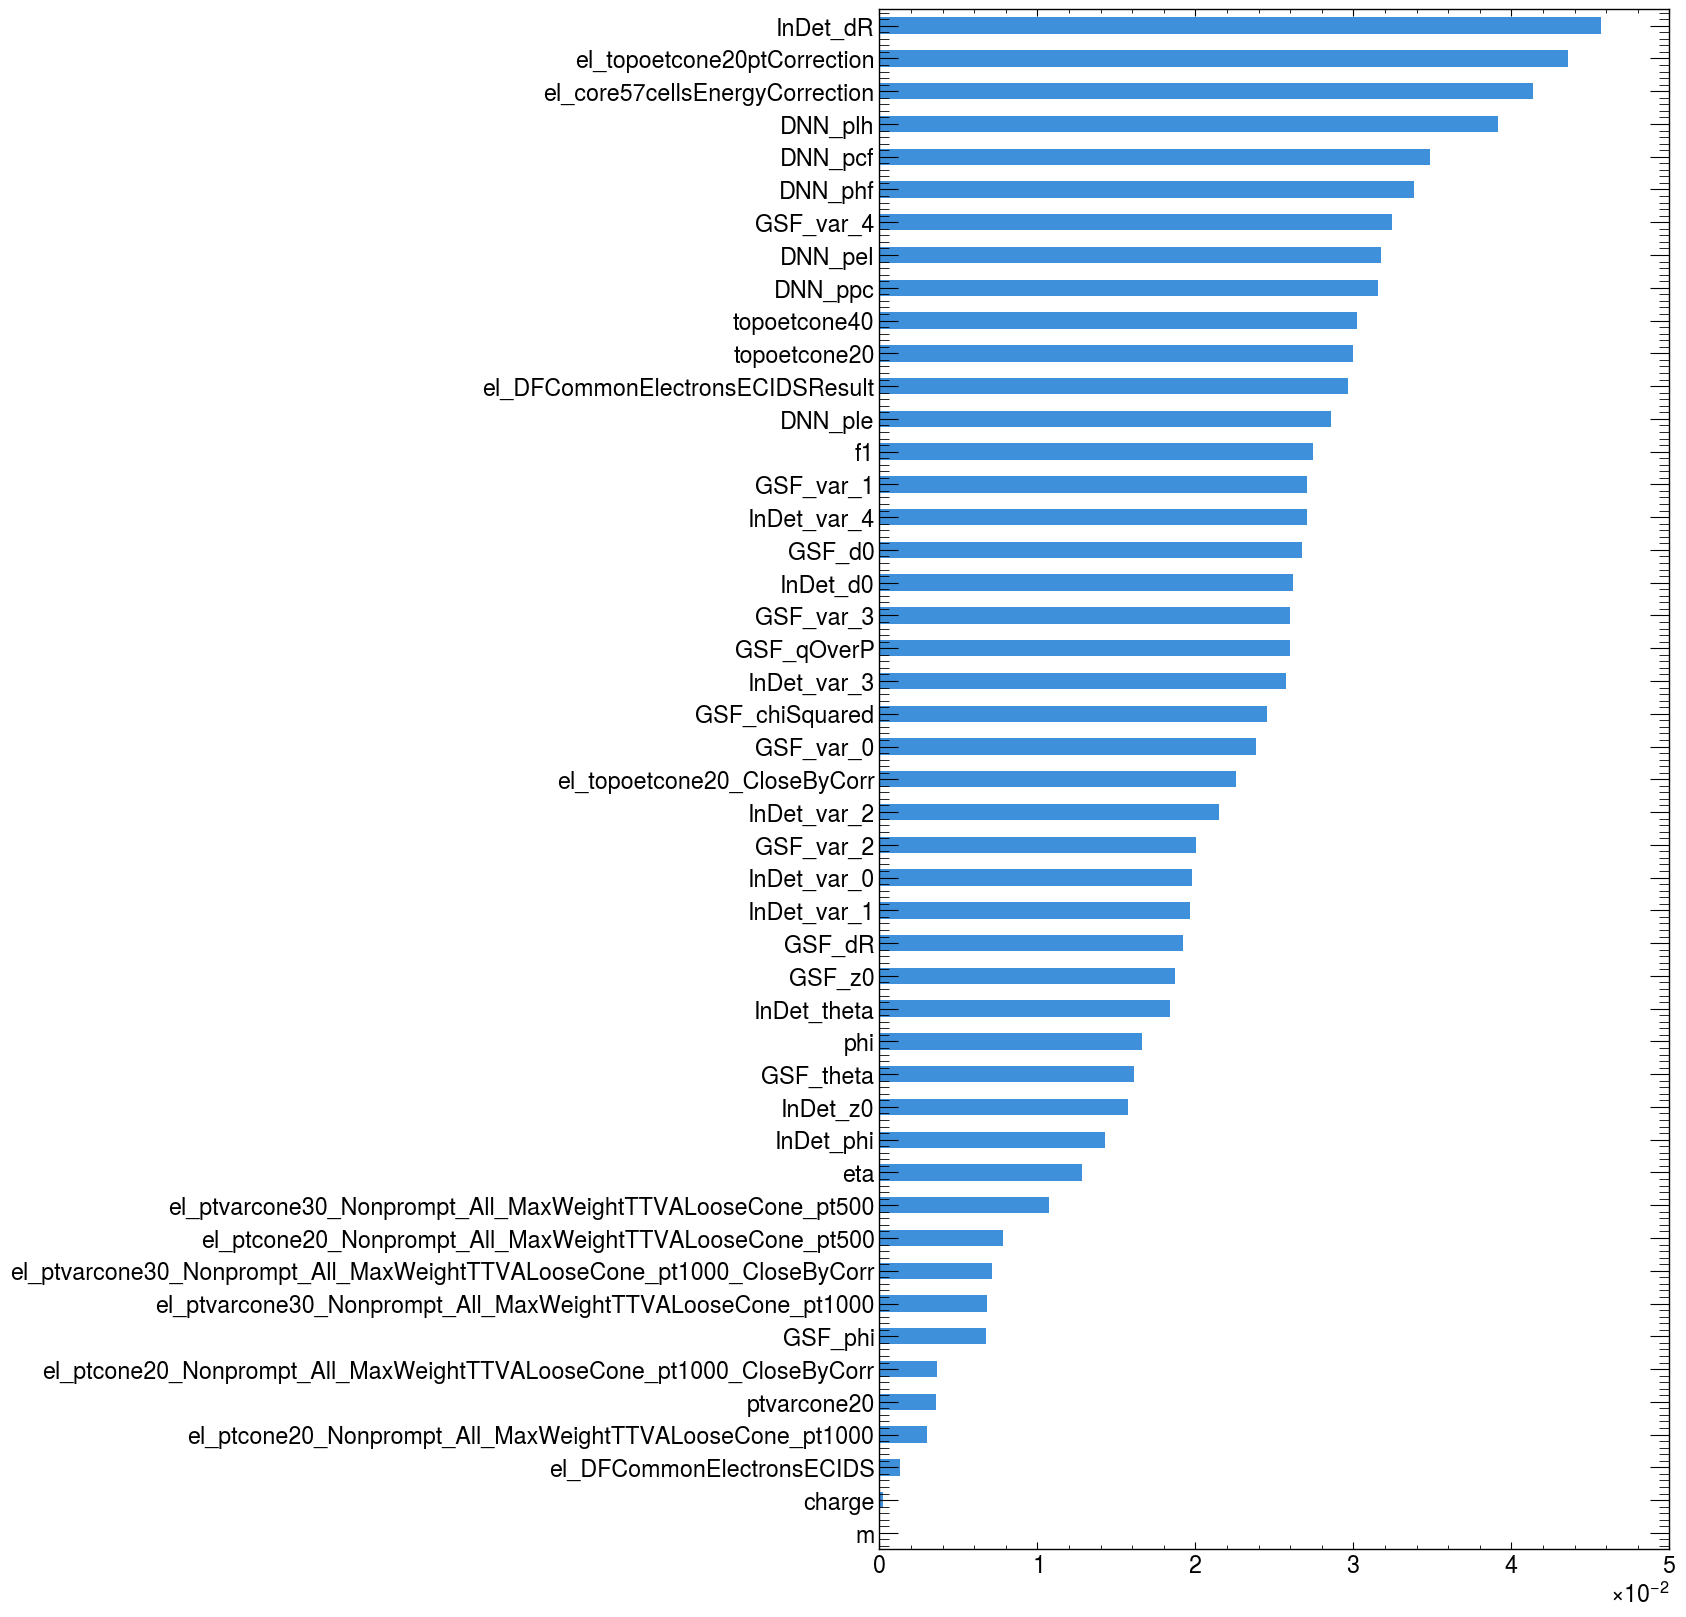

In [66]:
plt.rcdefaults()
hep.style.use([hep.style.ATLAS])

fig, ax = plt.subplots(figsize=(10, 20))
tuner.feature_importances.sort_values().plot(ax=ax,kind='barh')
# ax.set_xticklabels(tuner.feature_importances.sort_values().index, rotation=45)
print('no')

Text(0.5, 1.0, 'Receiver Operating Characteristic')

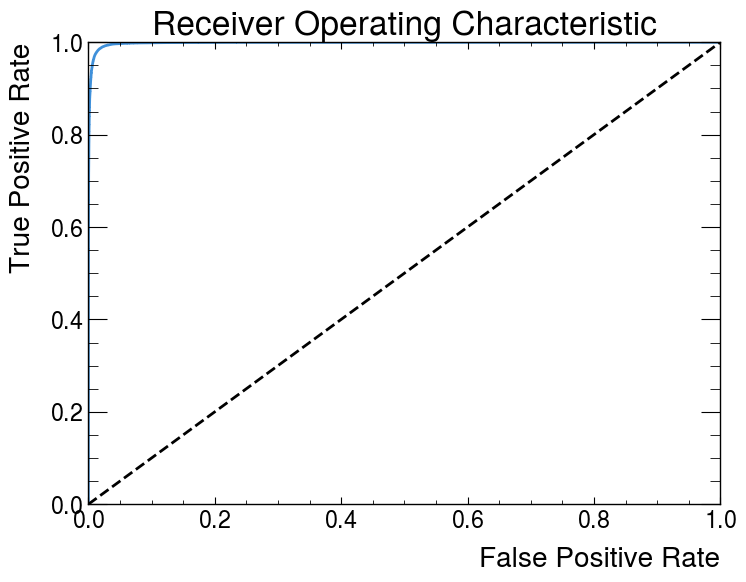

In [54]:
# roc curve
y_pred = tuner.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Luck')
ax.set_xlim([0, 1.0])
ax.set_ylim([0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic')